In [1]:
import numpy as np
import scipy.sparse as sparse
from sklearn import neighbors, svm, naive_bayes
import matplotlib.pyplot as pl
%matplotlib inline

## Test learning on pretraining dataset

In [2]:
metadata_path = '~/audiosearch/data/UrbanSound8K/metadata/UrbanSound8K_by_fold.csv'
fold_path = '/home/mzhan/audiosearch/data/UrbanSound8K/folds.csv'
class_path = '/home/mzhan/audiosearch/data/UrbanSound8K/classes.csv'
feature_path = '/home/mzhan/audiosearch/data/UrbanSound8K/features2.npy'
centroid_path = '/home/mzhan/audiosearch/data/UrbanSound8K/centroids151209.npy'


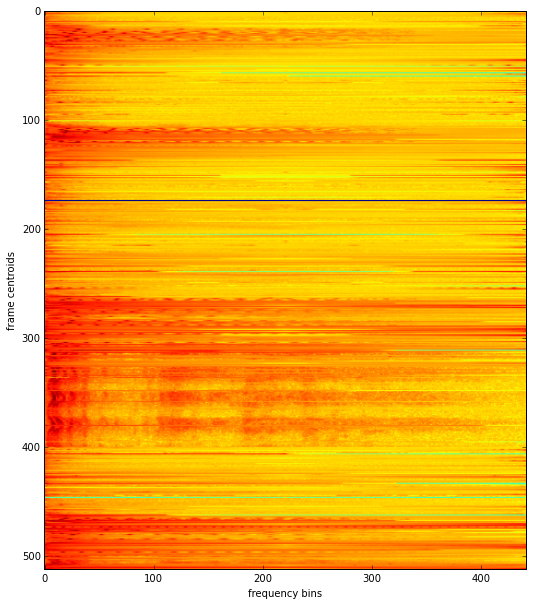

In [3]:
centroids = np.load(centroid_path)
pl.figure(figsize=(20,10))
pl.imshow(centroids[0,7])
pl.ylabel('frame centroids')
pl.xlabel('frequency bins')

## data partition

In [4]:
# Load and display data
X = np.load(feature_path)
Y = np.loadtxt(class_path)

<matplotlib.colorbar.Colorbar instance at 0x7fb14b3ee170>

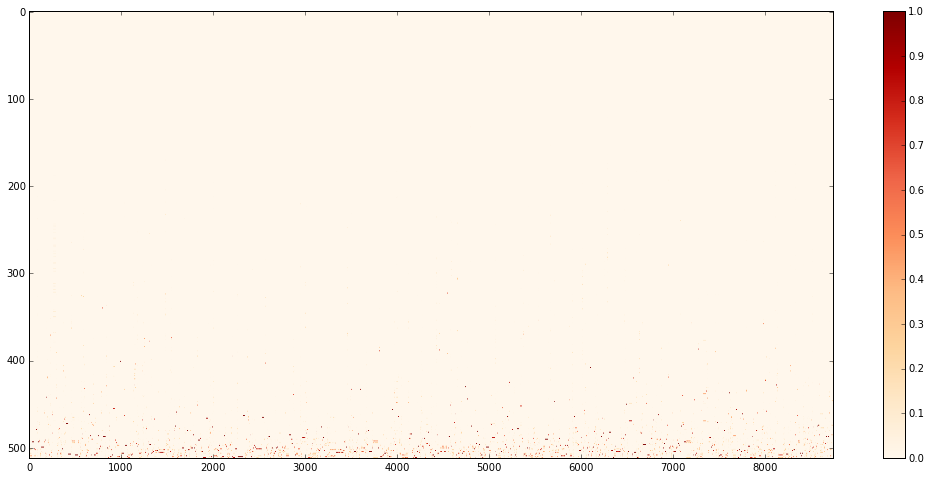

In [6]:
sums = X.sum(1).reshape((len(X),1))
normalized = np.divide(X, sums, dtype=float)

# sort features
sort_inds = normalized.sum(0).argsort()
sortedX = normalized[:,sort_inds]

pl.figure(figsize=(18,8))
pl.imshow(sortedX.T, aspect='auto', cmap = pl.get_cmap('OrRd'))
#pl.ylim([256, 511])
pl.colorbar()


Many features don't matter much...

In [7]:
cut = 200
Xcut = sortedX[:, :cut]
print np.max(Xcut), np.median(Xcut), np.mean(Xcut)
print np.sum(Xcut>0.01), 'files contain features of frequciecies greater than 0.1'

Xreduced = X[:,cut:]

0.118925831202 0.0 3.84449241717e-06
157 files contain features of frequciecies greater than 0.1


In [12]:
# training split
import random
random.seed(12345)
fold_partition = range(10)
random.shuffle(fold_partition)
folds = np.loadtxt(fold_path)


In [72]:
train = fold_partition[:5]
validate = fold_partition[5]
test = fold_partition[6:]



print train, validate, test
train_inds = np.any([folds == f for f in train], axis=0)
ntrain = train_inds.sum()
print ntrain
validate_inds = (folds == validate)
nval = validate_inds.sum()
print nval
test_inds = np.any([folds == f for f in test], axis=0)
ntest = test_inds.sum()
print ntest
print len(folds), ntrain+nval+ntest

[9, 2, 6, 8, 4] 1 [3, 0, 5, 7]
4352
888
3492
8732 8732


## Classification: Basic

In [16]:
def train(c, train_inds, cut, verbose=False):
    c.fit(sortedX[train_inds,cut:], Y[train_inds])
    if verbose:
        ntrain = train_inds.sum()
        correct = (c.predict(sortedX[train_inds, cut:])==Y[train_inds])
        print correct.sum()*1./ntrain
   
def validate(c, validate_inds, cut):
    nval = validate_inds.sum()
    vcorrect = (c.predict(sortedX[validate_inds, cut:])==Y[validate_inds])
    return vcorrect.sum()*1./nval

def crossvalidate(c):
    print c
    cv = []
    for f in fold_partition[:6]:
        validate_inds = (folds == f)
        nval = validate_inds.sum()
        train_inds = np.any([folds == ft for ft in fold_partition[:6] if ft!=f ], axis=0)
        ntrain = train_inds.sum()

        train(c, train_inds, cut)
        cv.append(validate(c, validate_inds,cut))
    return cv


#### Nearest Neighbor

In [169]:
for N in range(6,11):   # model selection
    c1 = neighbors.KNeighborsClassifier(n_neighbors=N)
    cv_score = crossvalidate(c1)
    print 'Nearest neighbor classifier with %d neighbors: '%N, np.mean(cv_score)
    print cv_score

Nearest neighbor classifier with 6 neighbors:  0.322918513613
[0.34528076463560337, 0.28540540540540543, 0.29236276849642007, 0.38848039215686275, 0.31517094017094016, 0.3108108108108108]
Nearest neighbor classifier with 7 neighbors:  0.322912311806
[0.33333333333333331, 0.30054054054054052, 0.29952267303102625, 0.38112745098039214, 0.30876068376068377, 0.3141891891891892]
Nearest neighbor classifier with 8 neighbors:  0.325965346138
[0.32138590203106332, 0.30486486486486486, 0.3054892601431981, 0.3860294117647059, 0.3215811965811966, 0.31644144144144143]
Nearest neighbor classifier with 9 neighbors:  0.323085957785
[0.31899641577060933, 0.307027027027027, 0.3054892601431981, 0.38480392156862747, 0.32264957264957267, 0.29954954954954954]
Nearest neighbor classifier with 10 neighbors:  0.324578863854
[0.31899641577060933, 0.30594594594594593, 0.30787589498806683, 0.38480392156862747, 0.32692307692307693, 0.30292792792792794]


In [22]:
c1 = neighbors.KNeighborsClassifier(n_neighbors=8)
cv_score = crossvalidate(c1)
print np.mean(cv_score), cv_score

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=8, p=2, weights='uniform')
0.315128494379 [0.32302405498281789, 0.24108108108108109, 0.38725490196078433, 0.3504273504273504, 0.29900744416873448, 0.28997613365155134]


#### SVM

one-against-one svm is slow and doesn't work well...

In [21]:
c2 = svm.SVC()
cv2 = crossvalidate(c2)
print np.mean(cv2), cv2

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
0.142650683416 [0.2313860252004582, 0.18378378378378379, 0.10049019607843138, 0.15277777777777779, 0.096774193548387094, 0.090692124105011929]


one-against-all much faster and better performance

In [20]:
c3 = svm.LinearSVC()
cv3 = crossvalidate(c3)
print np.mean(cv3), cv3

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
0.286527591177 [0.3218785796105384, 0.26162162162162161, 0.32598039215686275, 0.25854700854700857, 0.27667493796526055, 0.27446300715990452]


#### Naive Bayes

In [19]:
c4 = naive_bayes.GaussianNB()
cv4 = crossvalidate(c4)
print np.mean(cv4), cv4

GaussianNB()
0.263817458549 [0.3356242840778923, 0.19783783783783784, 0.29044117647058826, 0.27243589743589741, 0.24193548387096775, 0.24463007159904535]


In [207]:
#p = c4.predict_proba(sortedX[validate_inds,cut:])
p = c4.predict_proba(sortedX[validate_inds,cut:])

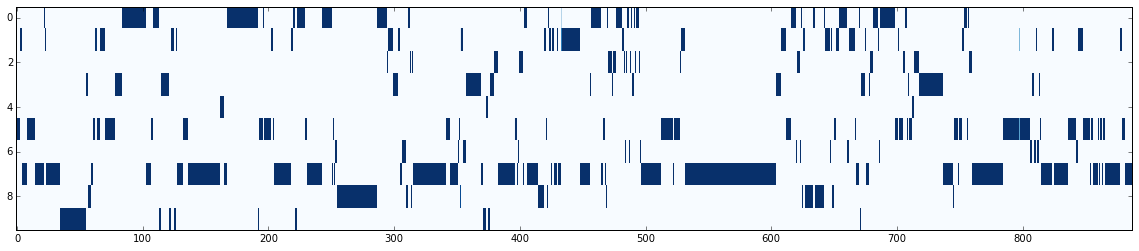

In [208]:
pl.figure(figsize=(20,4))
pl.imshow(p.T, aspect='auto', cmap = pl.get_cmap('Blues'), interpolation='nearest')

## Now see how interaction aids learning

Naive Bayes

In [230]:
print type(p), type(Y)
print Y[validate_inds].shape, p.shape

<type 'numpy.ndarray'> <type 'numpy.ndarray'>
(888,) (888, 10)


<matplotlib.colorbar.Colorbar instance at 0x7f5d414306c8>

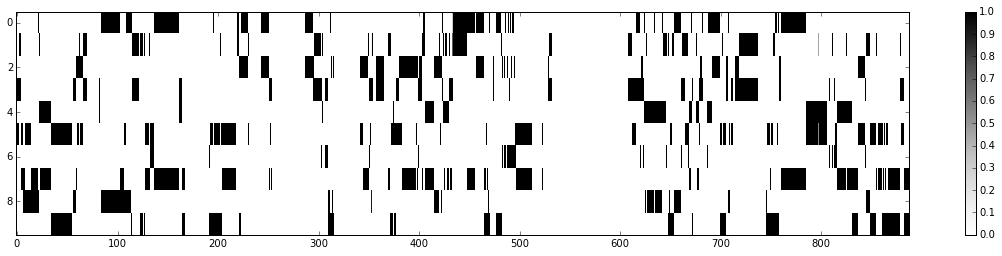

In [272]:
# Soft error
y = np.zeros(p.shape)
y[range(len(p)),Y[validate_inds].astype(int)]=1

E = np.abs(np.subtract(y,p))
pl.figure(figsize=(20,4))
pl.imshow(E.T, aspect='auto', cmap = pl.get_cmap('Greys'), interpolation='nearest')
pl.colorbar()

In [281]:
E.sum()

1289.9976820759971

In [282]:
# Hard error
phard = c4.predict(sortedX[validate_inds,cut:])
Ehard = np.abs(np.subtract(Y[validate_inds],phard))
Ehard.sum()

2315.0

### As binary classification

In [15]:
# Suppose we want to find dog barks (classID=3)
target_class = 3 
Yb = (Y==target_class)

c = neighbors.KNeighborsClassifier(n_neighbors=8)
crossvalidate(c)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_neighbors=8, p=2, weights='uniform')


[0.32302405498281789,
 0.24108108108108109,
 0.38725490196078433,
 0.3504273504273504,
 0.29900744416873448,
 0.28997613365155134]

In [18]:
# Suppose we want to find dog barks (classID=3)
target_class = 3 
Yb = (Y==target_class)

#c = neighbors.KNeighborsClassifier(n_neighbors=8)
c = naive_bayes.GaussianNB()
crossvalidate(c)


GaussianNB()


[0.3356242840778923,
 0.19783783783783784,
 0.29044117647058826,
 0.27243589743589741,
 0.24193548387096775,
 0.24463007159904535]

In [17]:
cut

200